# 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

Kaggle의 bike sharing 데이터셋을 이용해 기초적인 회귀 모델 활용 데이터분석 프로젝트를 진행한다.

## 목차

- 들어가며
- "사용 연수"로 맥북 가격 예측
  - 데이터 확인
  - 모델을 만든다는 것?
  - 손실함수 정의(one feature)
  - 손실함수를 줄이는 법
  - 분할 학습
- feature matrix로 tip 예측
  - 데이터 확인
  - 손실함수 재정의(features)
  - Gradient 계산
  - 모델 학습
  - 라이브러리 사용
- 프로젝트 1
- 프로젝트 2
- 회고
- Ref

## 들어가며

수학적인 내용이 많이 나올 예정

머신러닝을 수학적으로 깊게 이해함

In [1]:
from IPython.display import display, Image

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

## "사용 연수"로 맥북 가격 예측

In [3]:
from zipfile import ZipFile
import pandas as pd
import wget
import os

url = 'https://d3s0tskafalll9.cloudfront.net/media/documents/macbook_data.zip'
file = 'data/macbook_data'

In [4]:
if not os.path.isfile(file + '.zip'):
  wget.download(url, file + '.zip')

  with ZipFile(file + '.zip', 'r') as zipObj:
    zipObj.extractall(file)

### 데이터 확인

In [5]:
macbook = pd.read_csv(file + '/data/macbook.csv')
print(macbook.shape)
macbook.head()

(80, 2)


,used_years,price
0,2.65,175
1,3.80,63
2,0.95,273
3,4.50,133
4,4.45,106


`features = [사용 연수]`

`target = [가격]`

데이터 시각화
***

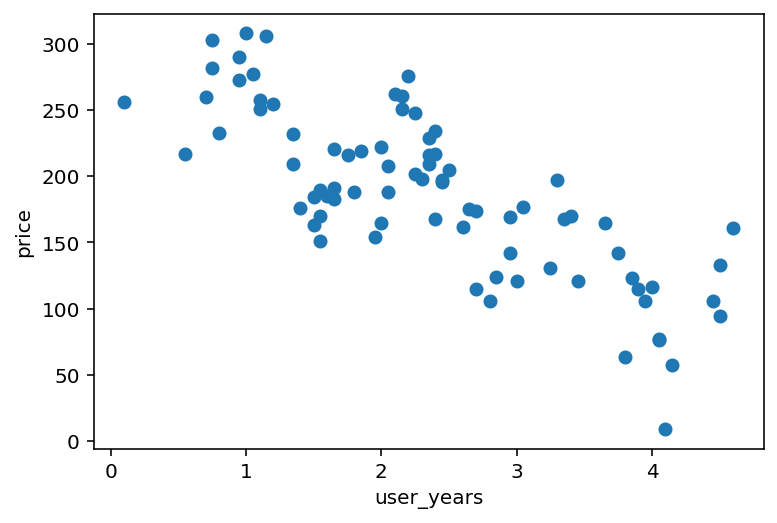

In [6]:
plt.scatter(macbook['used_years'], macbook['price'])
plt.xlabel('user_years')
plt.ylabel('price')
plt.show()

상관관계
***

[![00](img/00.png)](https://ko.wikipedia.org/wiki/피어슨_상관_계수)

- 두 변수가 얼마나 직선에 가까운지 확인하는 것!
- 두 변수의 기울기는 중요한 요소가 아님!
- 두 변수 간의 [**인과관계**](https://ko.wikipedia.org/wiki/상관관계와_인과관계)를 파악하는 것이 아님!
  - 인과관계 역전
    - 소방관이 많음 -> 화재 규모 큼
    - 소방관이 많으면 화재가 커진다
  - 제3의 요인이 2 요인의 공통 원인
    - 아이스크림 매상 증가 -> 익사자 수 증가
    - 아이스크림은 익사의 원인
  - 우연의 일치
    - 해적 감소 -> 지구온난화 문제 증가
    - 지구 온난화은 해적 감소의 원인
  - 사로 한쪽이 다른 한 쪽의 원인(비례 관계)
    - 압력 상승 -> 온도 상승
    - 압력은 온도 상승 원인

상관관계 실습
***

[![01](img/01.png)](https://m.blog.naver.com/kiddwannabe/221763497317)

[[ 1.         -0.78972238]
 [-0.78972238  1.        ]]


<AxesSubplot:>

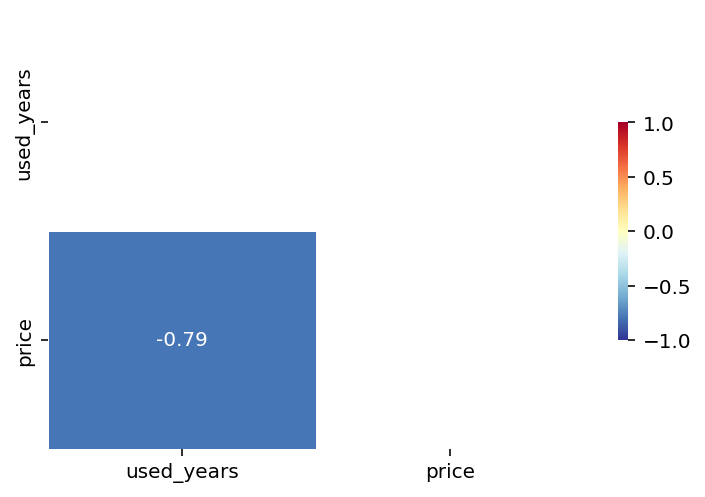

In [7]:
import seaborn as sns
import numpy as np

corr = np.corrcoef(macbook['used_years'], macbook['price'])
print(corr)

# corr 시각화 해보자!
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
  corr, # 데이터
  xticklabels = ['used_years', 'price'], # x 축 레이어
  yticklabels = ['used_years', 'price'], # y 축 레이어
  cmap = 'RdYlBu_r',  # 색
  annot = True, # 값을 출력한다
  mask = mask,  # 표시하지 않는 부분이 있음
  linewidths = .5,  # 경계면 실선으로 구분
  cbar_kws = {"shrink":.5}, # 컬러바 크기 줄이기
  vmin = -1,  # 컬러바 최소 범위
  vmax = 1    # 컬러바 최대 범위
)

### 모델을 만든다는 것?

[![02](img/02.gif)](https://runestone.academy/ns/books/published/fopp/Functions/Returningavaluefromafunction.html)

**모델(model)** 은 정보를 토대로 값을 예측하는 함수!

즉, X와 y가 있음

풀고자 하는 문제가 무엇인가?(문제 정의)
***

사용 연수(X) -> 중고가 예측(y)

In [8]:
x = macbook['used_years'].values
y = macbook['price'].values

일차함수 모델
***

In [9]:
def model(X, w, b):
  y = w * X + b
  return y

보통 `y = ax + b`로 나타냄

하지만, 인공지능에서는 `y = wx + b`로 나타냄

- w : weight(가중치)
- b : bias(편향)

모델 학습이란?
***

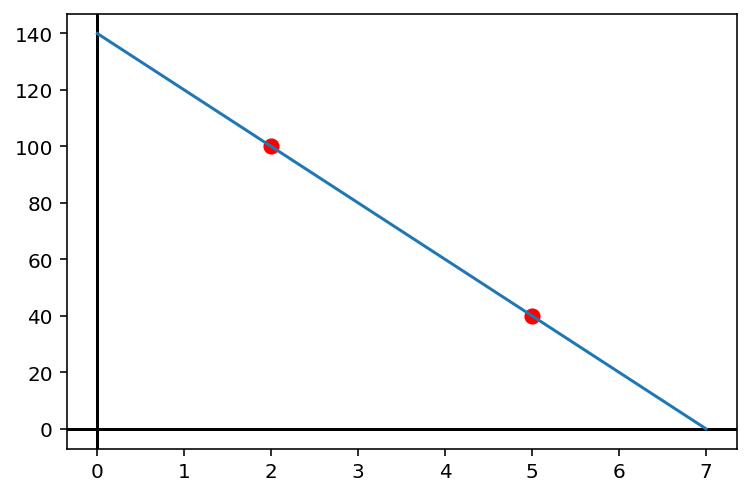

In [10]:
# x축, y축 그리기
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

# 나의 (x, y) 점 찍기
x_data = [2, 5]
y_data = [100, 40]
plt.scatter(x_data, y_data, c='r', s=50)

# y = wx + b 일차함수 그리기
x = np.linspace(0, 7, 2)
y = model(x, w=-20, b=140) # y = -20x + 140
plt.plot(x, y)

입력을 받았을 때, 정답에 가까운 최적의 `매개변수`, `파라미터(parameter)`를 찾아 냄

방정식을 푼다!

- 여기서는 이차 연립 방정식을 토대로 w와 b를 예측함

> - 40 = w * 5 + b
> - 100 = w * 2 + b

> - -60 = w * 3
> - -20 = w

> - 100 = -20 * 2 + b
> - 140 = b

오차를 최소화하는 모델
***

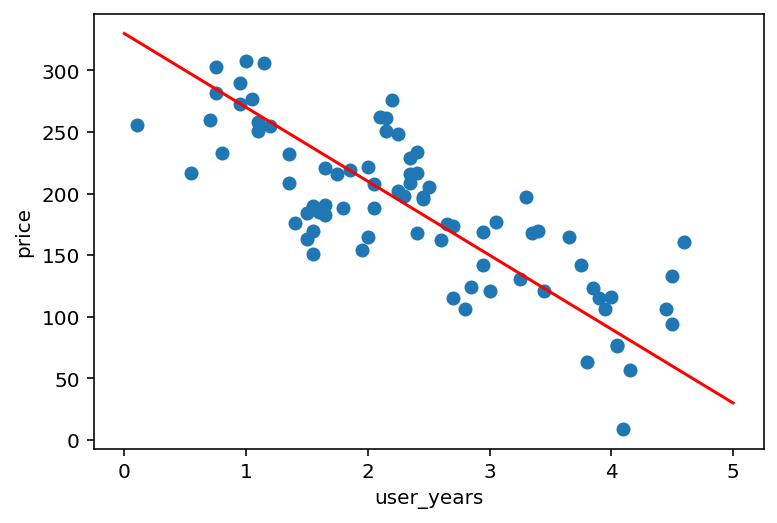

In [11]:
plt.scatter(macbook['used_years'], macbook['price'])
plt.xlabel('user_years')
plt.ylabel('price')

# 대충 그어봄
x = [0, 5]
y = [330, 30]
plt.plot(x, y, c = 'r')
plt.show()

실제 데이터는 연립 방정식으로 풀 수 없음

### 손실함수 정의(one feature)

**최적의** 함수는 어떻게 찾을 수 있을까?
***

손실함수를 토대로 차이점을 체크함

모델의 출력값과 실제값 간의 차이를 확인한다!

이 차이를 줄이는 것이 목표!

예시
***

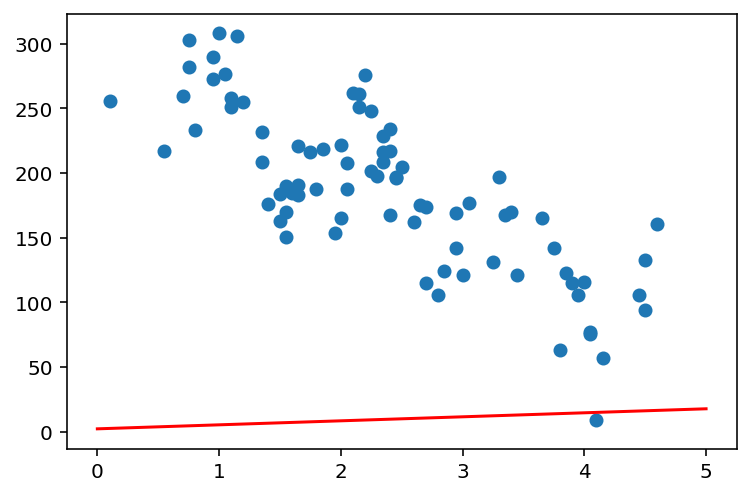

In [12]:
# 최초 설정
w = 3.1
b = 2.3

x = np.linspace(0, 5, 2)
y = model(x, w, b) # y = 3.1x + 2.3
plt.plot(x, y, c='r')

plt.scatter(macbook['used_years'], macbook['price'])
plt.show()

In [13]:
X = macbook["used_years"].values
prediction = model(X, w, b) # 현재 w = 3.1, b = 2.3
macbook['prediction'] = prediction
macbook.head()

,used_years,price,prediction
0,2.65,175,10.515
1,3.80,63,14.080
2,0.95,273,5.245
3,4.50,133,16.250
4,4.45,106,16.095


손실 함수의 종류(regression 한정)
***

- MAE(Mean Abasolute Error)
  - ![03](img/03.jpeg)
  - ![04](img/04.jpeg)
- MSE(Mean Squared Error)
  - ![05](img/05.jpeg)
  - ![06](img/06.jpeg)
- MPE(Mean Percentage Error)
  - ![07](img/07.jpeg)
  - ![08](img/08.jpeg)
- MAPE(Mean Absolute Percentage Error)
  - ![09](img/09.jpeg)
  - ![10](img/10.jpeg)
- RMSE(Root Mean Squared Error) = MSE ** 0.5
- R ** 2(coefficient of determination)
  - ![11](img/11.png)
  - ![12](img/12.png)
- adjusted R ** 2(조정 결정 계수)
  - ![13](img/13.png)
  - ![14](img/14.png)

In [14]:
macbook['error'] = macbook['price'] - macbook['prediction']
macbook.head()

,used_years,price,prediction,error
0,2.65,175,10.515,164.485
1,3.80,63,14.080,48.920
2,0.95,273,5.245,267.755
3,4.50,133,16.250,116.750
4,4.45,106,16.095,89.905


In [15]:
def RMSE(a, b):
  mse = ((a - b) ** 2).mean()  # 두 값의 차이의 제곱의 평균
  rmse = mse ** 0.5        # MSE의 제곱근
  return rmse

In [16]:
y = macbook['price']
RMSE(prediction, y)

188.81322969819274

손실 함수(loss function) == 비용 함수(cost function)
***

In [17]:
def loss(X, w, b, y):
    predictions = model(X, w, b)
    L = RMSE(predictions, y)
    return L

### 손실함수를 줄이는 법

기울기와 경사하강법(Gradient Descent)
***

[![15](img/15.gif)](https://www.youtube.com/watch?v=IHZwWFHWa-w)

- 우리가 변경 가능한 변수는 `w`, `b`!
- 최적의 `w`를 찾기 위해 어떻게 접근하는가?
- `기울기(gradient)`를 토대로 접근하자!
  - 음의 기울기라면 w를 늘리고
  - 양의 기울기라면 w를 줄인다
- `w' = w - a * g`
  - `w'` : 새로운 기울기
  - `w` : 과거 기울기
  - `a` : 얼마나 업데이트 하는가?(learning rate)
  - `g` : 기울기(Gradient)

미분으로 경사 구하기
***

결국 수학... [미분](https://ko.wikipedia.org/wiki/미분)을 해야함

근사 미분으로 접근하자!

In [18]:
def gradient(x, w, b, y):
  dw = (loss(x, w + 0.0001, b, y) - loss(x, w, b, y)) / 0.0001
  db = (loss(x, w, b + 0.0001, y) - loss(x, w, b, y)) / 0.0001
  return dw, db

### 분할 학습

하이퍼 파라미터(Hyper Parameter)
***

In [19]:
learning_rate = 1

사람이 직접 사전에 정하고 시작해야 하는 파라미터!

모델 최적화
***

정리

- 입력 데이터 X와 정답 데이터 y 준비
- 초기 w, b 랜덤하게 선택
- pred 하고 y와 계산을 통해 손실값 계산
- 손실값을 통해 gradient 계산
- 각각 update
- 3 ~ 5 반복

In [20]:
# 입력 데이터 X와 정답 데이터 y 준비
X = macbook['used_years'].values
y = macbook['price'].values

# 초기 w, b 랜덤하게 선택
w, b = 3.1, 2.3

# 손실함수 변화 저장
losses = []

# 3 ~ 5 반복
for i in range(1, 2001):
  # pred 하고 y와 계산을 통해 손실값 계산
  # 손실값을 통해 gradient 계산
  dw, db = gradient(X, w, b, y)
  # 각각 update
  w -= learning_rate * dw
  b -= learning_rate * db

  # 손실함수 변화 저장
  L = loss(X, w, b, y)
  losses.append(L)

  if i % 500 == 0:
    print(f'Iteration{i} : Loss {L}')

Iteration500 : Loss 59.97780534427
Iteration1000 : Loss 39.142009857087984
Iteration1500 : Loss 38.31788318858529
Iteration2000 : Loss 38.303841049095496


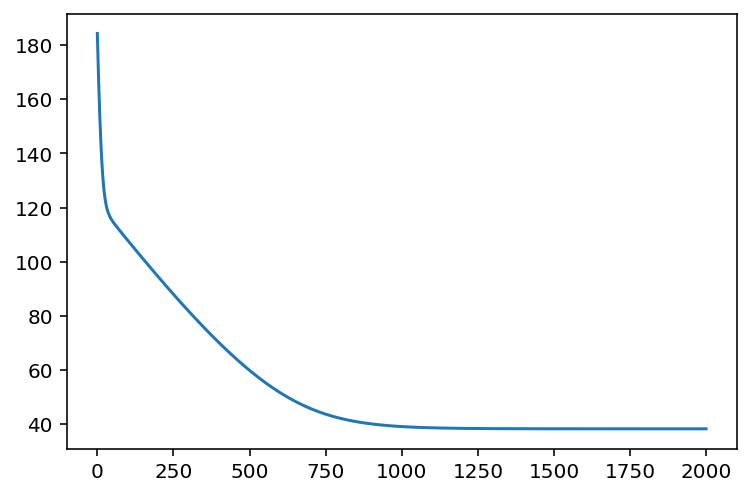

In [21]:
plt.plot(losses)

loss 변경된 모습

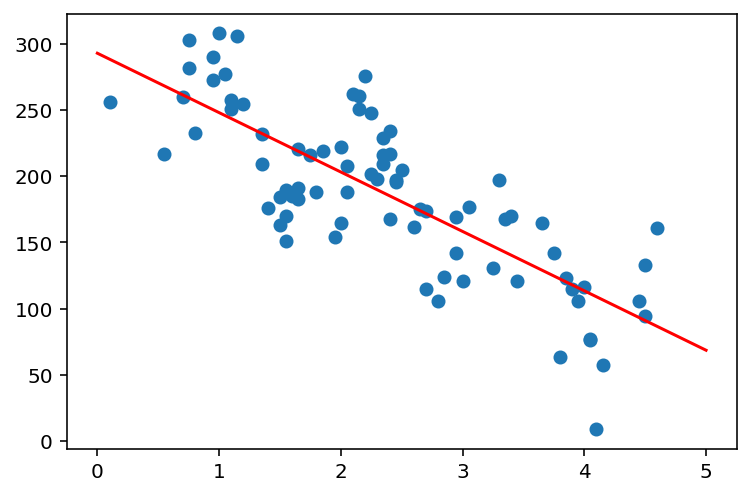

In [22]:
# 모델에 넣을 x 값들 준비
x = np.linspace(0, 5, 2)

# x, w, b를 모델에 넣어 y값 출력
y = model(x, w, b)

# 일차함수 y 그리기
plt.plot(x, y, c="r")


# 원본 데이터 점찍기
plt.scatter(macbook['used_years'], macbook['price'])

test 데이터로 검증하기

In [23]:
test = pd.read_csv(file + "/data/macbook_test.csv")
print(test.shape)
test.head()

(20, 2)


,used_years,price
0,1.20,203
1,1.85,206
2,2.40,191
3,2.85,164
4,3.05,176


In [24]:
test_X = test['used_years'].values
test_y = test['price'].values

In [25]:
prediction = model(test_X, w, b)
test['prediction'] = prediction

In [26]:
test['error'] = test['price'] - test['prediction']

In [27]:
rmse = ((test['error'] ** 2).sum() / len(test)) ** 0.5
rmse

45.03918284717212

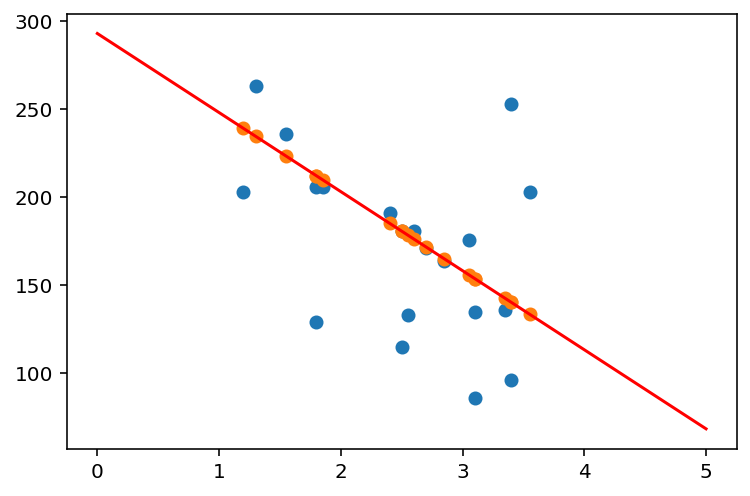

In [28]:
# 모델 일차함수 그리기
x = np.linspace(0, 5, 2)
y = model(x, w, b)
plt.plot(x, y, c="r")

# 실제 데이터 값
plt.scatter(test['used_years'], test['price'])

# 모델이 예측한 값
plt.scatter(test['used_years'], test['prediction'])

## feature matrix로 tip 예측

### 데이터 확인

[![16](img/16.png)](https://matplotlib.org/cheatsheets/)

[![17](img/17.png)](http://seaborn.pydata.org/)

다양한 데이터를 다양한 방법으로 시각화 하자!

matplotlib

seaborn

In [29]:
import seaborn as sns

# 다양한 시각화 연습 데이터 셋
print(sns.get_dataset_names())

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'exercise', 'flights', 'fmri', 'gammas', 'geyser', 'iris', 'mpg', 'penguins', 'planets', 'taxis', 'tips', 'titanic']


In [30]:
tips = sns.load_dataset("tips")
print(tips.shape)
tips.head()

(244, 7)


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


features

- total_bill : 테이블 지불 금액
- tip : 팁
- sex : 계산한 손님 성별
- smoker : 흡연자 포함 여부
- day : 요일
- time : 시간
- size : 인원 수

linear regression은 categry 데이터를 사용할 수 없음

이때 [더미 변수](https://kkokkilkon.tistory.com/37)(Dummy Variable == 가변수)를 사용해야함

In [31]:
import pandas as pd
tips = pd.get_dummies(tips, columns=['sex', 'smoker', 'day', 'time'])
tips.head()

,total_bill,tip,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
0,16.99,1.01,2,0,1,0,1,0,0,0,1,0,1
1,10.34,1.66,3,1,0,0,1,0,0,0,1,0,1
2,21.01,3.50,3,1,0,0,1,0,0,0,1,0,1
3,23.68,3.31,2,1,0,0,1,0,0,0,1,0,1
4,24.59,3.61,4,0,1,0,1,0,0,0,1,0,1


선형 회귀
***

다양한 변수를 토대로 선형 방정식을 만듬

y = w0 + x1w1 + x2w2 + ... + xnwn

최종 결과를 시각화하여 볼 수 없음

- 3차원 이상의 모습을 그려낼 수 없기 떄문

### 손실함수 재정의(features)

In [32]:
# 입력값 나누기
X = tips[['total_bill', 'size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No',
          'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner']].values
y = tips['tip'].values

In [33]:
from sklearn.model_selection import train_test_split

# train과 test 셋 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(195, 12) (195,)
(49, 12) (49,)


In [34]:
import numpy as np
# 학습에 사용할 레이어 지정
W = np.random.rand(X.shape[1])
b = np.random.rand()

In [35]:
def model(X, W, b):
    return X.dot(W) + b

In [36]:
def MSE(a, b):
  return ((a - b)  ** 2).mean()

In [37]:
def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

In [38]:
loss(X,W,b,y)

87.56181335675706

### Gradient 계산

![18](img/18.png)

현재 가지고 있는 `w`들과 `b`를 미분하여 사용해야함

한 변수에 있어 미분을 실시하면, 나머지 모든 변수들은 사라지게 됨

- `(w0 + x1w1 + x2w2) ** 2`에 대한 w0 미분은 `2`
- `(w0 + x1w1 + x2w2) ** 2`에 대한 w1 미분은 ` 2 * x1`
- `(w0 + x1w1 + x2w2) ** 2`에 대한 w2 미분은 ` 2 * x2`


In [39]:
def gradient(X, W, b, y):
    # N은 가중치의 개수
    N = len(W)
    
    # y_pred 준비
    y_pred = model(X, W, b)
    
    # 공식에 맞게 gradient 계산
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    # b의 gradient 계산
    db = 2 * (y_pred - y).mean()
    return dW, db

In [40]:
dW, db = gradient(X, W, b, y)

### 모델 학습

학습을 위해 학습률을 설정하자!

In [41]:
learning_rate = 0.1 ** 4

In [42]:
losses = []

for i in range(1, 1001):
    dW, db = gradient(X_train, W, b, y_train)
    W -= learning_rate * dW
    b -= learning_rate * db
    L = loss(X_train, W, b, y_train)
    losses.append(L)
    if i % 200 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 200 : Loss 1.4709
Iteration 400 : Loss 1.3476
Iteration 600 : Loss 1.2802
Iteration 800 : Loss 1.2368
Iteration 1000 : Loss 1.2062


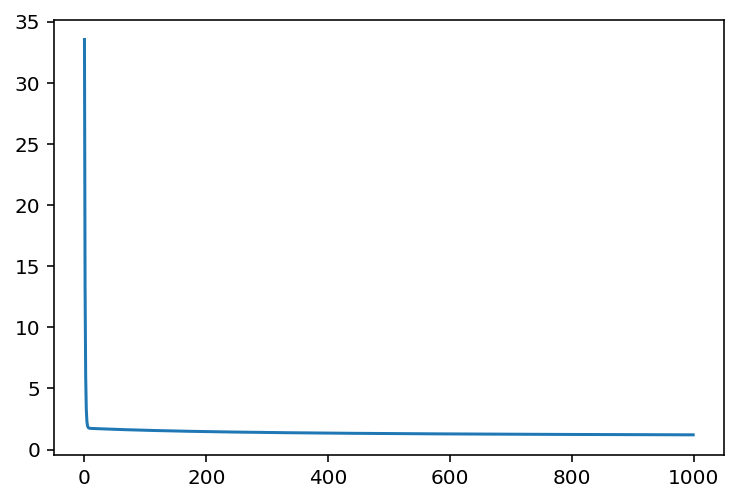

In [43]:
plt.plot(losses)

In [44]:
prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)
mse

0.687595741178664

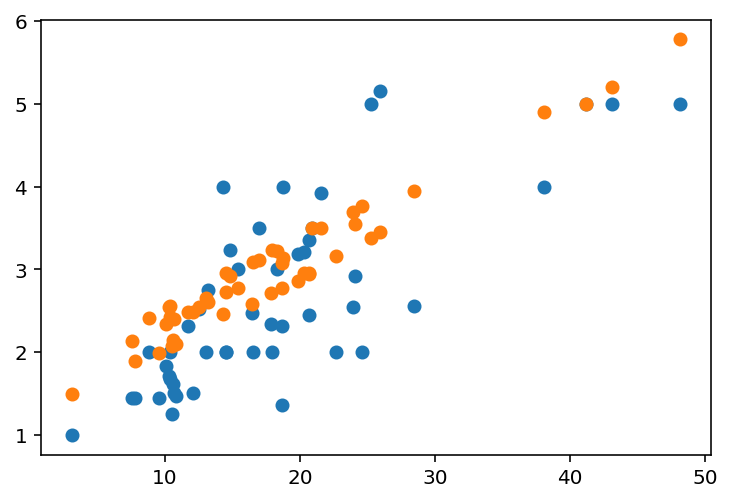

In [45]:
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], prediction)

### 라이브러리 사용

라이브러리로 쉽게 코드를 짜보자

In [46]:
tips = sns.load_dataset('tips')
tips = pd.get_dummies(tips, columns=['sex', 'smoker', 'day', 'time'])
X = tips.drop('tip', axis=1).values
y = tips['tip'].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [49]:
model.fit(X_train, y_train)

LinearRegression()

In [50]:
predictions = model.predict(X_test)

In [51]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse

0.7033566017436103

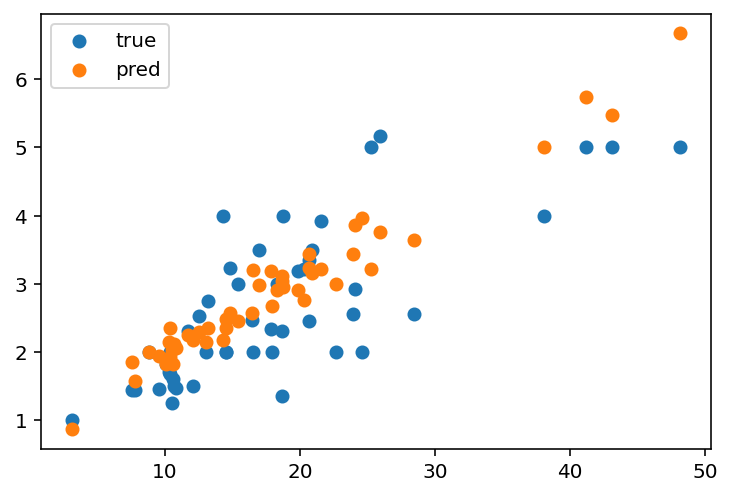

In [52]:
plt.scatter(X_test[:, 0], y_test, label="true")
plt.scatter(X_test[:, 0], predictions, label="pred")
plt.legend()

정리
***

- X, y, pred 개념 이해
- model == func 이해
- loss func 이해 및 종류를 배움
- gradient는 학습에 필요함
  - loss 미분을 통해 구할 수 있음
  - 미분은 수치와 해석으로 나뉨
- linear regression process를 이해
- sklearn을 통한 간편한 진행 학습


## 프로젝트 1 : sklearn 사용하지 않고 당뇨 수치 예측

데이터 가져오기

모델에 입력할 데이터 X 준비하기

모델에 예측할 데이터 y 준비하기

train 데이터와 test 데이터로 분리하기

모델 준비하기

손실 함수 `loss` 정의하기

기울기 구하는 `gradient` 함수 구현하기

하이퍼 파라미터인 학습률 설정하기

모델 학습하기

test 데이터에 대한 성능 확인하기

정답 데이터와 예측한 데이터 시각화하기

## 프로젝트 2 : 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

데이터 가져오기

In [53]:
#!pip3 kaggle

In [54]:
!pip3 list | grep kaggle

kaggle                       1.5.12


In [55]:
# https://medium.com/analytics-vidhya/fetch-data-from-kaggle-with-python-9154a4c610e3

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [56]:
data_names = api.competitions_list(search='bike')
data_names

ApiException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Content-Length': '0', 'Date': 'Fri, 15 Jul 2022 11:03:37 GMT', 'Access-Control-Allow-Credentials': 'true', 'Set-Cookie': 'ka_sessionid=4a162ba9be8e370ce99b6751918fcbad; max-age=2626560; path=/, GCLB=CKT_56eRwJaNcQ; path=/; HttpOnly', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/competitions/list?group=&category=&sortBy=&page=1&search=bike', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-JUbKPTp0yTj0SAwzP50MKQ==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://form.jotform.com https://submit.jotform.us https://submit.jotformpro.com https://submit.jotform.com https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kaggle-static-staging.storage.googleapis.com https://kkb-dev.jupyter-proxy.kaggle.net https://kkb-staging.jupyter-proxy.kaggle.net https://kkb-production.jupyter-proxy.kaggle.net https://kkb-dev.firebaseapp.com https://kkb-staging.firebaseapp.com https://kkb-production.firebaseapp.com https://kaggle-metastore-test.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})


In [ ]:
api.competition_list_files(competition=str(data_names[0]))

[sampleSubmission.csv, test.csv, train.csv]

In [ ]:
api.competition_download_files(str(data_names[0]), 'data')
with ZipFile(f'data/{data_names[0]}.zip') as zf:
  zf.extractall(f'data/{data_names[0]}') 

`datetime` 컬럼을 `datetime` 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

년, 월, 일, 시, 분, 초 데이터 갯수 시각화 하기

X, y 컬럼 선택 및 train/test 데이터 분리

LinearRegression 모델 학습

학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

x축은 `temp` or `humidity`로 y축은 `count`로 예측 결과 시각화하기

## 회고

배우고 궁금한 것
***

어려웠는 것
***

시도한 것
***

실패한 것과 그 이유
***

## Ref

|날짜|제목(링크)|내용|
|:-:|:--------:|:--:|
|?|[피어슨 상관 계수](https://ko.wikipedia.org/wiki/피어슨_상관_계수)|상관 계수 계산법과 예제|
|?|[상관관계와_인과관계](https://ko.wikipedia.org/wiki/상관관계와_인과관계)|상관 관계는 즉 인과관계가 아니다!|
|20.01.08|[상관관계 분석 시각화](https://m.blog.naver.com/kiddwannabe/221763497317)|상관관계 heatmap 시각화|
|?|[function](https://runestone.academy/ns/books/published/fopp/Functions/Returningavaluefromafunction.html)|함수 gif 추출 사용|
|18.09.26|[Tutorial: Understanding Regression Error Metrics in Python](https://www.dataquest.io/blog/understanding-regression-error-metrics/)|regression error 종류|
|17.04.04|[R-squared의 의미](https://igija.tistory.com/256)|r ** 2의 의미|
|21.08.28|[Adjusted R-Squared](https://towardsdatascience.com/demystifying-r-squared-and-adjusted-r-squared-52903c006a60)|adjusted r ** 2의 의미와 사용법|
|19.04.27|[경사 하강, 신경 네트워크가 학습하는 방법](https://www.youtube.com/watch?v=IHZwWFHWa-w)|Gradient Descent 설명 youtube|
|17.03.28|[Dummy Variable](https://kkokkilkon.tistory.com/37)|범주형을 어떻게 수치형으로 바꾸는가?|
|20.05.04|[fetch data from kaggle with python](https://medium.com/analytics-vidhya/fetch-data-from-kaggle-with-python-9154a4c610e3)|kaggle 데이터 받아 내는 법|